In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
%run PARAMETERS.py
NAME = 'VAE'
PATH = NAME + '-%dpts-%dsamples' % (N, SAMPLE_SIZE)
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
NUM_DATASETS = data.shape[0]
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))

In [3]:
from decoder_beta import *
from local_enc_state_beta import *
from local_enc_angle_beta import *
dec_x = Dec_x(K, D, NUM_HIDDEN_DEC, RECON_SIGMA, CUDA, DEVICE)
f_angle = Enc_angle(D, NUM_HIDDEN_ANGLE, CUDA, DEVICE)
f_state = Enc_state(K, D, NUM_HIDDEN_STATE, CUDA, DEVICE)

if CUDA:
    with torch.cuda.device(DEVICE):
        dec_x.cuda()
        f_angle.cuda()
        f_state.cuda()
optimizer =  torch.optim.Adam(list(f_angle.parameters())+list(f_state.parameters())+list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = data[batch_indices]
        mu = MU[batch_indices] + 0.5
        ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob =ob.cuda()
                mu = mu.cuda()
        q_state, p_state = f_state.forward(ob, mu, K)
        log_p_state = p_state['states'].log_prob
        log_q_state = q_state['states'].log_prob
        state = q_state['states'].value ## S * B * N * K
        q_angle, p_angle = f_angle(ob, state, mu)
        log_q_angle = q_angle['angles'].log_prob.sum(-1)
        log_p_angle = p_angle['angles'].log_prob.sum(-1)
        angle = q_angle['angles'].value
        p = dec_x(ob, state, angle, mu)
        ll = p['likelihood'].log_prob.sum(-1) ## S * B * N
        log_w =  ll.detach() + log_p_state + log_p_angle - log_q_state - log_q_angle
        w = F.softmax(log_w, 0).detach()
        loss_phi = (w * log_w).sum(0).sum(-1).mean()
        loss_theta = (- w * ll).sum(0).sum(-1).mean()
        ## gradient step
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()  
        LOSS += loss_theta.detach()
    if epoch % 1 == 0:
        time_end = time.time()
        print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, loss=3555.9280 (4s)
epoch=1, loss=147.3011 (4s)
epoch=2, loss=-47.6069 (4s)
epoch=3, loss=-56.1805 (4s)
epoch=4, loss=-58.3194 (4s)
epoch=5, loss=-62.6216 (4s)
epoch=6, loss=-66.8113 (4s)
epoch=7, loss=-69.6553 (4s)
epoch=8, loss=-72.6013 (4s)
epoch=9, loss=-75.6826 (4s)
epoch=10, loss=-79.1808 (4s)
epoch=11, loss=-82.5004 (4s)
epoch=12, loss=-84.9817 (4s)
epoch=13, loss=-86.7372 (4s)
epoch=14, loss=-87.9092 (4s)
epoch=15, loss=-88.8964 (4s)
epoch=16, loss=-89.3593 (4s)
epoch=17, loss=-89.9850 (4s)
epoch=18, loss=-90.3777 (4s)
epoch=19, loss=-90.7248 (4s)
epoch=20, loss=-91.0434 (4s)
epoch=21, loss=-91.4181 (4s)
epoch=22, loss=-91.6114 (4s)
epoch=23, loss=-92.1071 (4s)
epoch=24, loss=-92.2145 (4s)
epoch=25, loss=-92.7250 (4s)
epoch=26, loss=-93.0606 (3s)
epoch=27, loss=-93.4090 (4s)
epoch=28, loss=-93.6813 (4s)
epoch=29, loss=-93.8302 (4s)
epoch=30, loss=-94.2010 (4s)
epoch=31, loss=-94.3245 (4s)
epoch=32, loss=-94.3389 (4s)
epoch=33, loss=-94.6570 (4s)
epoch=34, loss=-94.9349

KeyboardInterrupt: 

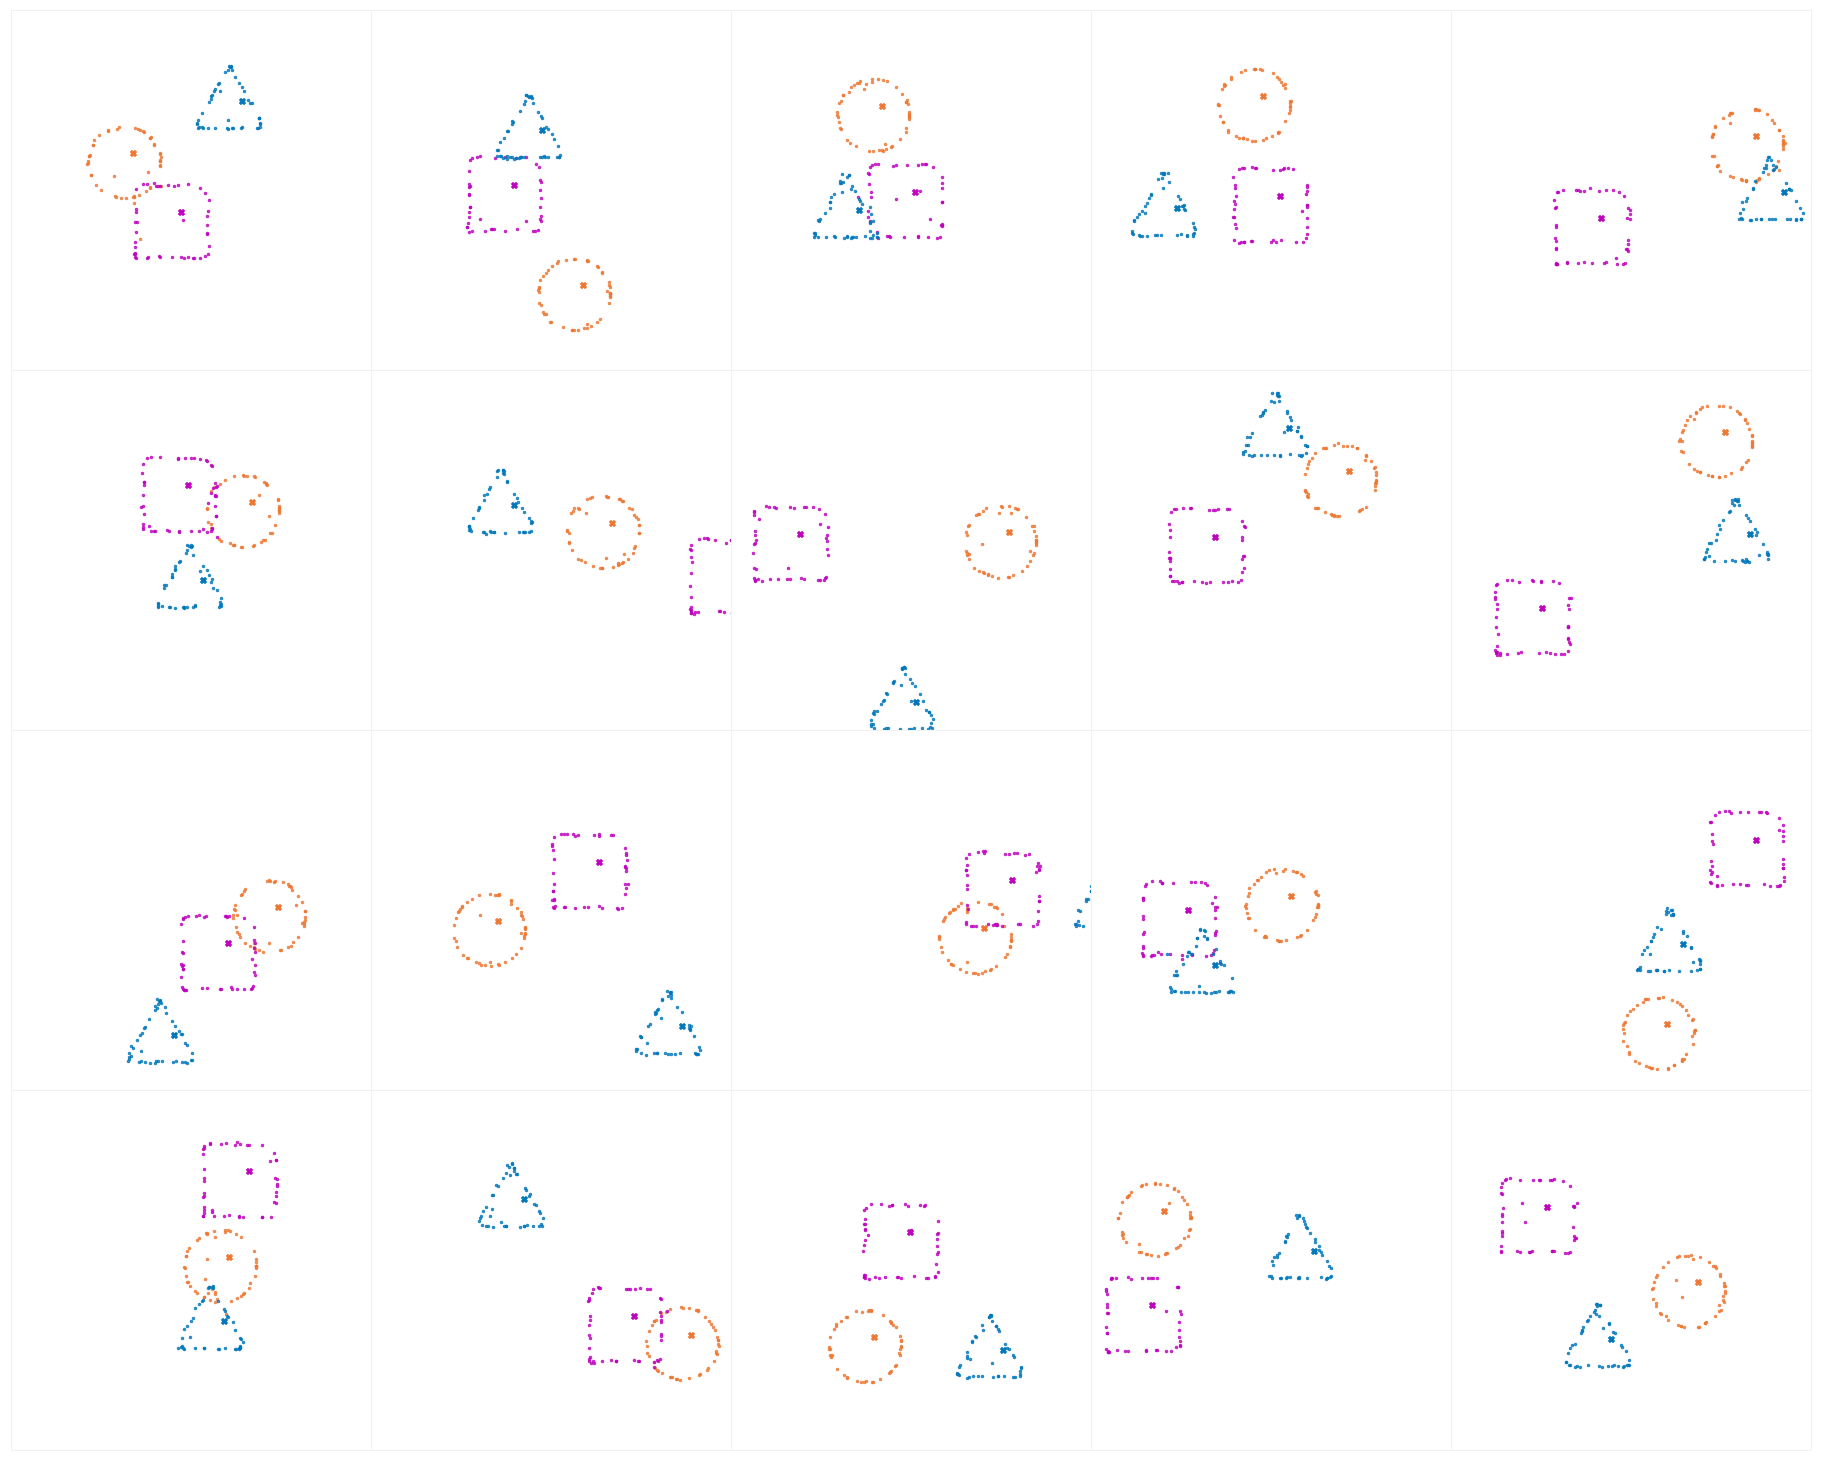

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from plots import plot_final_samples
    
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = data[batch_indices]
mu = MU[batch_indices] + 0.5
angle_true = ANGLE[batch_indices]
ob_embedding = torch.cat((ob, angle_true), -1)
ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        ob_embedding =ob_embedding.cuda()
        mu = mu.cuda()
ob = ob_embedding[:,:,:, :2]
angle_true = ob_embedding[:,:,:, -1].unsqueeze(-1)
q_state, p_state = f_state.forward(ob, mu, K)
log_p_state = p_state['states'].log_prob
log_q_state = q_state['states'].log_prob
state = q_state['states'].value ## S * B * N * K
q_angle, p_angle = f_angle(ob, state, mu)
log_q_angle = q_angle['angles'].log_prob.sum(-1)
log_p_angle = p_angle['angles'].log_prob.sum(-1)
angle = q_angle['angles'].value 
p = dec_x(ob, state, angle, mu)

E_state =  q_state['states'].dist.probs[0].cpu().data.numpy()
recon_mu = p['likelihood'].dist.loc[0].cpu().data.numpy()
plot_final_samples(recon_mu, mu[0].cpu().data.numpy(), E_state, K, PATH)

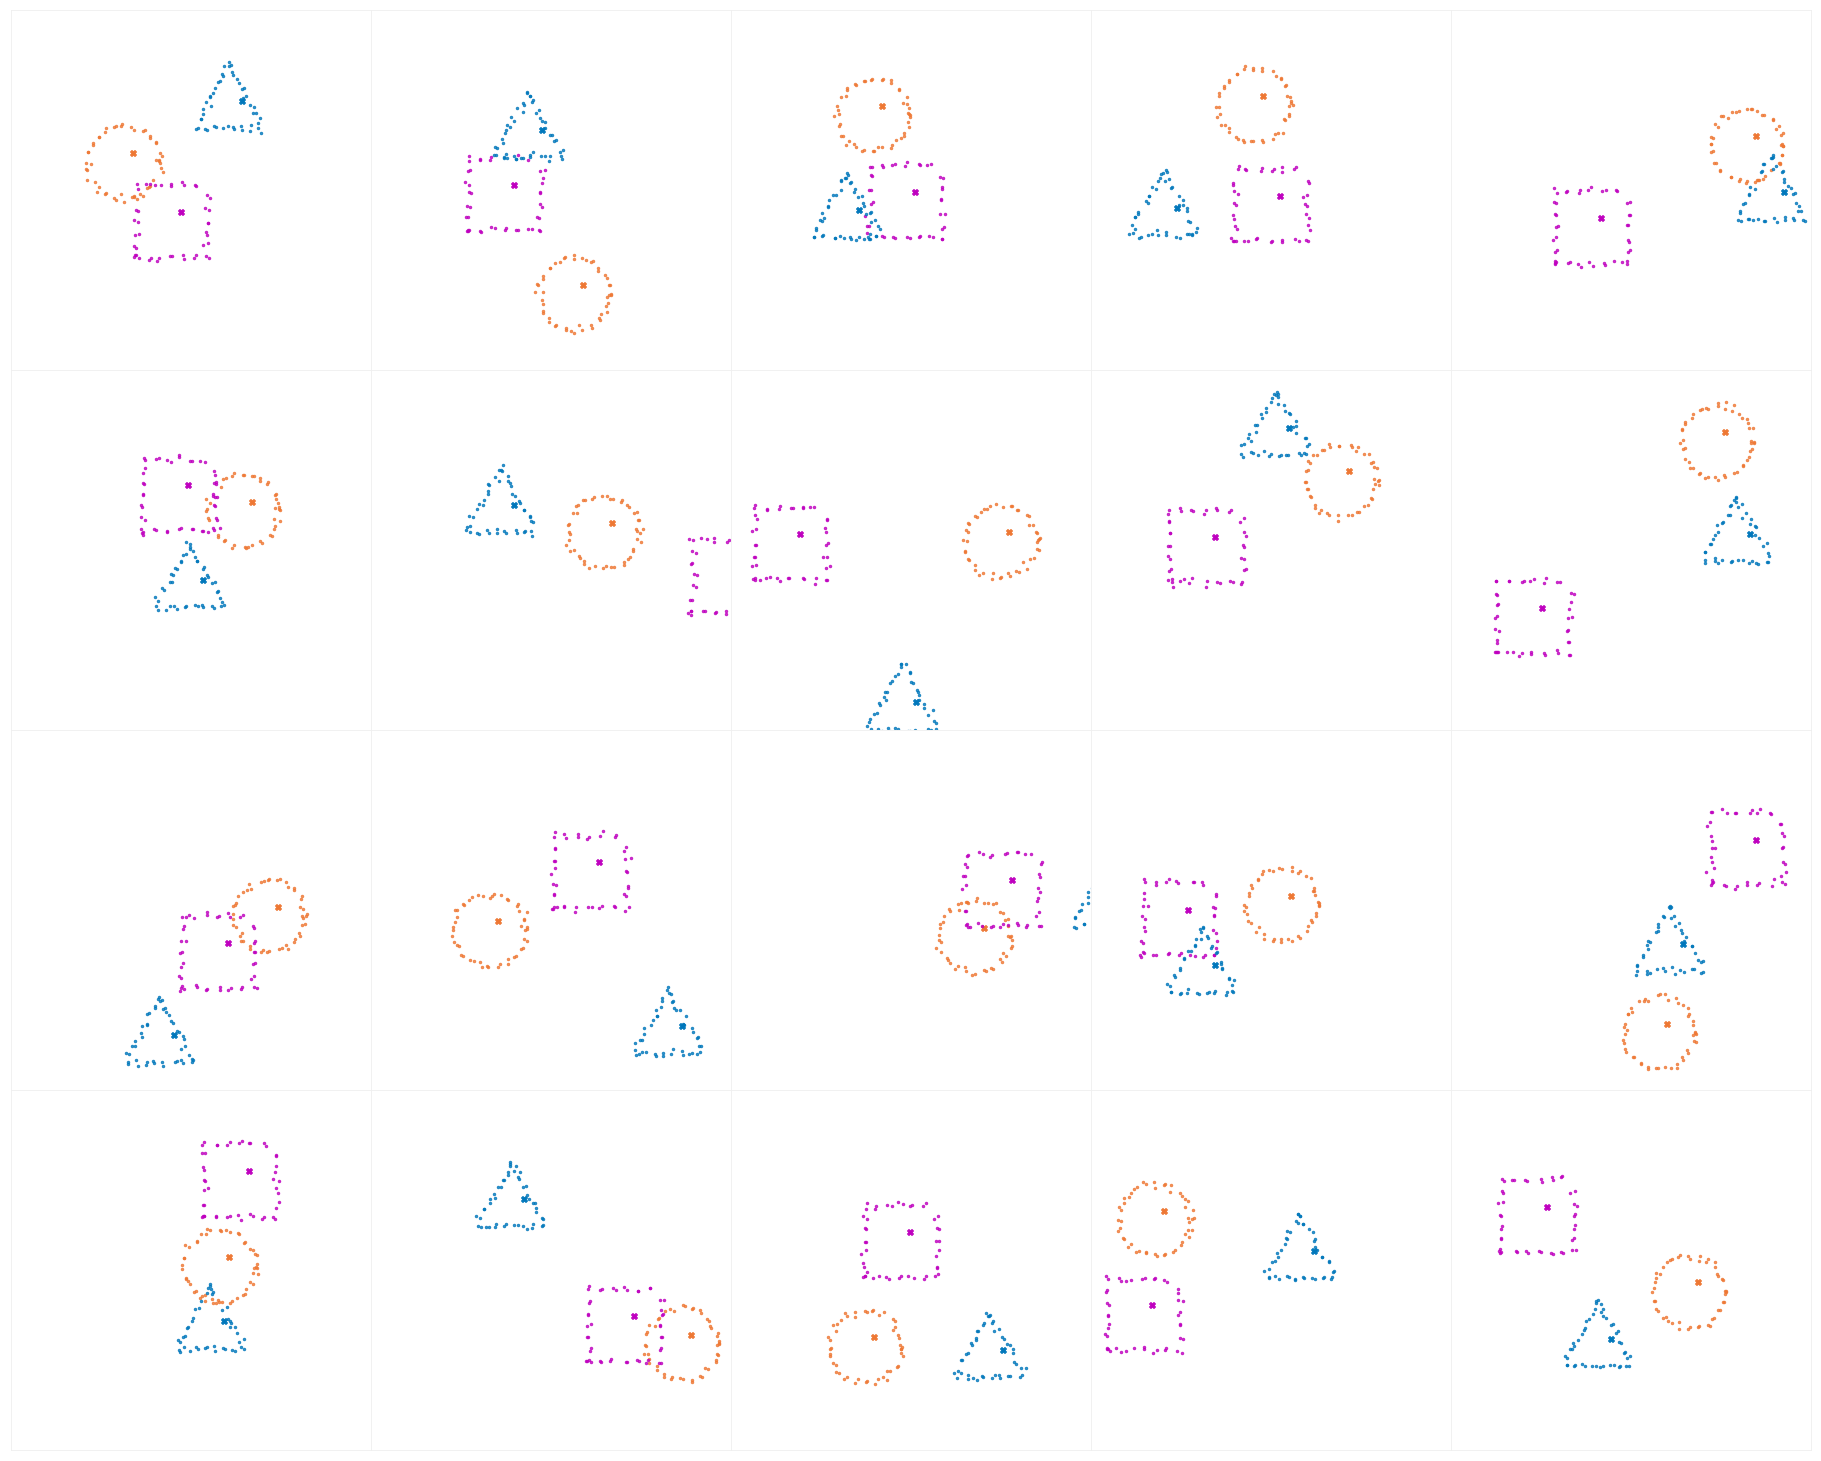

In [6]:
plot_final_samples(ob[0].cpu().data.numpy(), mu[0].cpu().data.numpy(), E_state, K, PATH)